In [47]:
import PIL
import os
import tensorflow as tf
import numpy as np
import pandas
from skimage.io import imread
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
import zipfile

In [48]:
directory_path = 'data/images/training_data'

In [49]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Can be 'int', 'categorical', or 'binary'
    validation_split=0.2,
    subset='training',
    seed=42
)

Found 3164 files belonging to 3 classes.
Using 2532 files for training.


In [50]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Can be 'int', 'categorical', or 'binary'
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 3164 files belonging to 3 classes.
Using 632 files for validation.


In [51]:
class_names = train_ds.class_names

In [52]:
tf.__version__

'2.14.0'

In [53]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(256,256,3),
    pooling='avg',
    classes=3
)
 
for layer in pretrained_model.layers:
    layer.trainable = False
    
resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(3, activation='softmax'))

In [54]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24638339 (93.99 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


This model does not compile on my machine. ChatGPT spit out the code for the model below

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model

# Define the input tensor
input_tensor = Input(shape=(256, 256, 3))

# Load the pre-trained ResNet50 model without the top layer
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    pooling='avg',
    classes=3,
    input_tensor=input_tensor
)

# Add a Flatten layer to convert the 4D output to 2D
flatten = layers.Flatten()(pretrained_model.output)

# Add a Dense layer with 128 units and ReLU activation
dense = layers.Dense(128, activation='relu')(flatten)

# Add the final output layer with 3 units and softmax activation
output = layers.Dense(3, activation='softmax')(dense)

# Create the model
model = Model(inputs=pretrained_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [56]:
resnet_model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [57]:
# check if trained raw model exists
if not os.path.exists('data/models/raw/resnet.keras'):
    # if zipped model doesnt exist as well, train the model and save raw model and zip raw model
    if not os.path.exists('data/models/zipped/resnet_zip.zip'):
        history = resnet_model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=10
        )
        # saving the model
        resnet_model.save('data/models/resnet.keras')
        # zipping the model
        with zipfile.ZipFile('data/models/zipped/resnet_zip.zip', 'w', zipfile.ZIP_DEFLATED) as zip:
            zip.write('data/models/raw/resnet.keras')
    # otherwise, zip exists and can unzip the model
    else:
        with zipfile.ZipFile('data/models/zipped/resnet_zip.zip', 'r') as zip:
            for file_info in zip.infolist():
                if file_info.filename.endswith('resnet.keras'):
                    file_info.filename = os.path.basename(file_info.filename) # extract only the filename
                    zip.extract(file_info, 'data/models/raw')
# load the trained model
imported_model = models.load_model('data/models/raw/resnet.keras')

In [58]:
from tensorflow.keras.preprocessing import image

In [59]:
img = image.load_img('data/images/training_data/cringe/18_1_1_image.png.53435437-65db-463c-b92e-17947f1aa14d.png', target_size=(256, 256))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

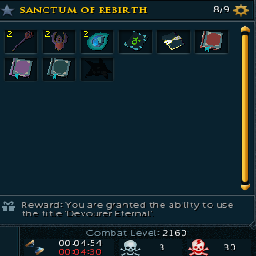

In [60]:
img

In [61]:
preds = imported_model.predict(img_arr)

1/1 [==============================] - 1s 1s/step


In [62]:
print('Predicted class is', class_names[np.argmax(preds)])

Predicted class is cringe
